# Libraries and functions

In [2]:
#Arrays and containers
import numpy as np
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
#import arviz as az

#Stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
!pip install pingouin
from pingouin import power_chi2
import pingouin as pg

#import pymc as pm
#import pytensor.tensor as pt
#import bambi as bmb
#print('Running on PyMC v{}'.format(pm.__version__))

#Other tools
import copy

  Obtaining dependency information for pingouin from https://files.pythonhosted.org/packages/eb/56/6d3607f3a78aee1de8e5466f5171722c8e344266a12dc44ccb73d024b3b3/pingouin-0.5.5-py3-none-any.whl.metadata
  Obtaining dependency information for pandas-flavor from https://files.pythonhosted.org/packages/67/1a/bfb5574b215f530c7ac5be684f33d60b299abbebd763c203aa31755f2fb2/pandas_flavor-0.6.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/204.4 kB ? eta -:--:--
   -- ------------------------------------- 10.2/204.4 kB ? eta -:--:--
   ---------------------- ----------------- 112.6/204.4 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 204.4/204.4 kB 1.8 MB/s eta 0:00:00


In [3]:
data_path = r'C:\Users\L03552670\Documents\GitHub\Marketing_Data_Analyses_TEC\Python\Data'+ "\\"
data_path 

'C:\\Users\\L03552670\\Documents\\GitHub\\Marketing_Data_Analyses_TEC\\Python\\Data\\'

# Load data


In [4]:
dataSF = pd.read_csv(data_path + "data_SF_clean.csv")
Amazon = pd.read_csv(data_path + "Amazon_Satisfaction_Clean.csv")

# Null hypothesis approach

### The (frequentist) hypothesis testing logic
We calculate a statistic from the data and test it against an hypothesis. Usually the null is a zero effect. That is we assume that the null is true

<br>

For example, the two independent sample t-test. 

$t_{stat} = \frac{(\bar{x_1}-\bar{x_2})-(\mu_a - \mu_b)}{\sqrt{\frac{\sigma^2_1}{n_1}+\frac{\sigma^2_2}{n_2}}}$ 

Note that our null hypothesis is expressed in the fact that $\mu_a - \mu_b = 0$ 

## Parametric

### Compare means of samples (t tests)

Assumptions:
1) Continuous data (or that we can think continuous)
2) Approx. normal
3) Similar variance
4) Random sample from population

Types

|                    |         One sample        | Two ind. samples |       Paired t-test      |
|--------------------|:-------------------------:|:----------------:|:---------------------------:|
| Description        | One group against a value |    Two groups    | One group repeated measures |
| Degrees of freedom |            n-1            |      n1+n2-2     |             n-1             |

### Compare means (one sample)

When you want to compare a variable against a hypothetical benchmark

In [5]:
#Let's check if the mean income is greater than a value
#Drop outliers (in the next cells we will see that Income is not normally distributed)
m = dataSF.loc[:, "Income"].mean()
s = dataSF.loc[:, "Income"].std()
idx = (dataSF.loc[:, "Income"]>m-3*s) & (dataSF.loc[:, "Income"]<m+3*s)
dataSF_r = dataSF.loc[idx,:]
print("Mean Income of Santa Fe Grill's Costumers: ", np.round(dataSF_r.loc[:, "Income"].mean(), 2), " dollars")


Mean Income of Santa Fe Grill's Costumers:  65527.36  dollars


Reflect: 
* Why should we care/measure about income levels? Is it important to Santa Fe Grill?
* What income level should be interesting to evaluate?

In [6]:
#Run the t-test traditionally
print("\nTraditional t-test: ", stats.ttest_1samp(dataSF_r.loc[:, "Income"], 50000), "\n\n")


Traditional t-test:  TtestResult(statistic=6.823239438816177, pvalue=3.297059748690066e-11, df=401) 




### Compare means (independent samples)

When you want to compare two unrelated groups.

In [7]:
#Let´s check the assumptions
#Continuous data? Income yes 
idx = dataSF_r.loc[:, "Gender"] == "Male"
Group_A = dataSF_r.loc[idx, "Income"]
Group_B = dataSF_r.loc[~idx, "Income"]
print("\nMale income: ", Group_A.mean(), 
      "\nFemale income: ", Group_B.mean())



Male income:  59309.16030534351 
Female income:  77164.28571428571


It seems that women earn more. Any explanation?

**We need to test such interesting finding: women clients that responded the Santa Fe survey earn more!**

Let's do a t-test to compare means

In [8]:
print("Two sample t-test: ", stats.ttest_ind(Group_A, Group_B)) #if p<0.05, both groups statistically differ

Two sample t-test:  TtestResult(statistic=-3.8001764709072297, pvalue=0.00016709301408705354, df=400.0)


The t-test seems to confirm the raw result. Before accepting such result, let's check assumptions of the t-test.

In [9]:
#First let's check assumptions
#Normal variable
print("Normality test Male: ", stats.shapiro(Group_A)) #normality test, p<0.05 no normality
print("Normality test Female: ", stats.shapiro(Group_B)) #normality test p<0.05 no normality

#Equal variances in both groups
print("\nLevene test for unequal variances")
print(stats.levene(Group_A, Group_B)) #p<0.05 different variances


Normality test Male:  ShapiroResult(statistic=0.8799636329143744, pvalue=1.6690291347953605e-13)
Normality test Female:  ShapiroResult(statistic=0.9192862737993099, pvalue=4.1942554208416333e-07)

Levene test for unequal variances
LeveneResult(statistic=7.668394600825488, pvalue=0.005881217864430857)


Ooops, the assumptions do not hold. We will return to this later, we can do non-parametric tests which relax the assumptions.

But a more conceptual assumption: Are male and female clients of Santa Fe grill truly independent? No. Why?

### Compare means (dependent samples, e.g. repeated measures in a panel)

Our original data does not have repeated measures. For pedagogical purposes, let's add one by adding an increase on income for all respondents

In [24]:
dataSF_panel = copy.deepcopy(dataSF_r)
salary_rise = np.random.normal(loc = 500, scale = 1000, size = dataSF_panel.shape[0])
dataSF_panel.insert(dataSF_panel.shape[1],
                    "Income_t2", dataSF_panel.loc[:, "Income"] + salary_rise)


In [26]:
#Traditionally
print("Two dependent sample t-test: ", 
      stats.ttest_rel(dataSF_panel.loc[:, "Income"], dataSF_panel.loc[:, "Income_t2"]) )


Two dependent sample t-test:  TtestResult(statistic=-10.406914395117195, pvalue=1.299942898380466e-22, df=401)


As expected, because we increased the salary from t1 to t2, the t-test is significant (p<0.05)

### Compare means (ANOVA)

An ANOVA is a linear regression with categorical predictor variables. 

<img src="ANOVA_Regr.png" alt="image description" width="250" height="150"/>




These are the assumptions:

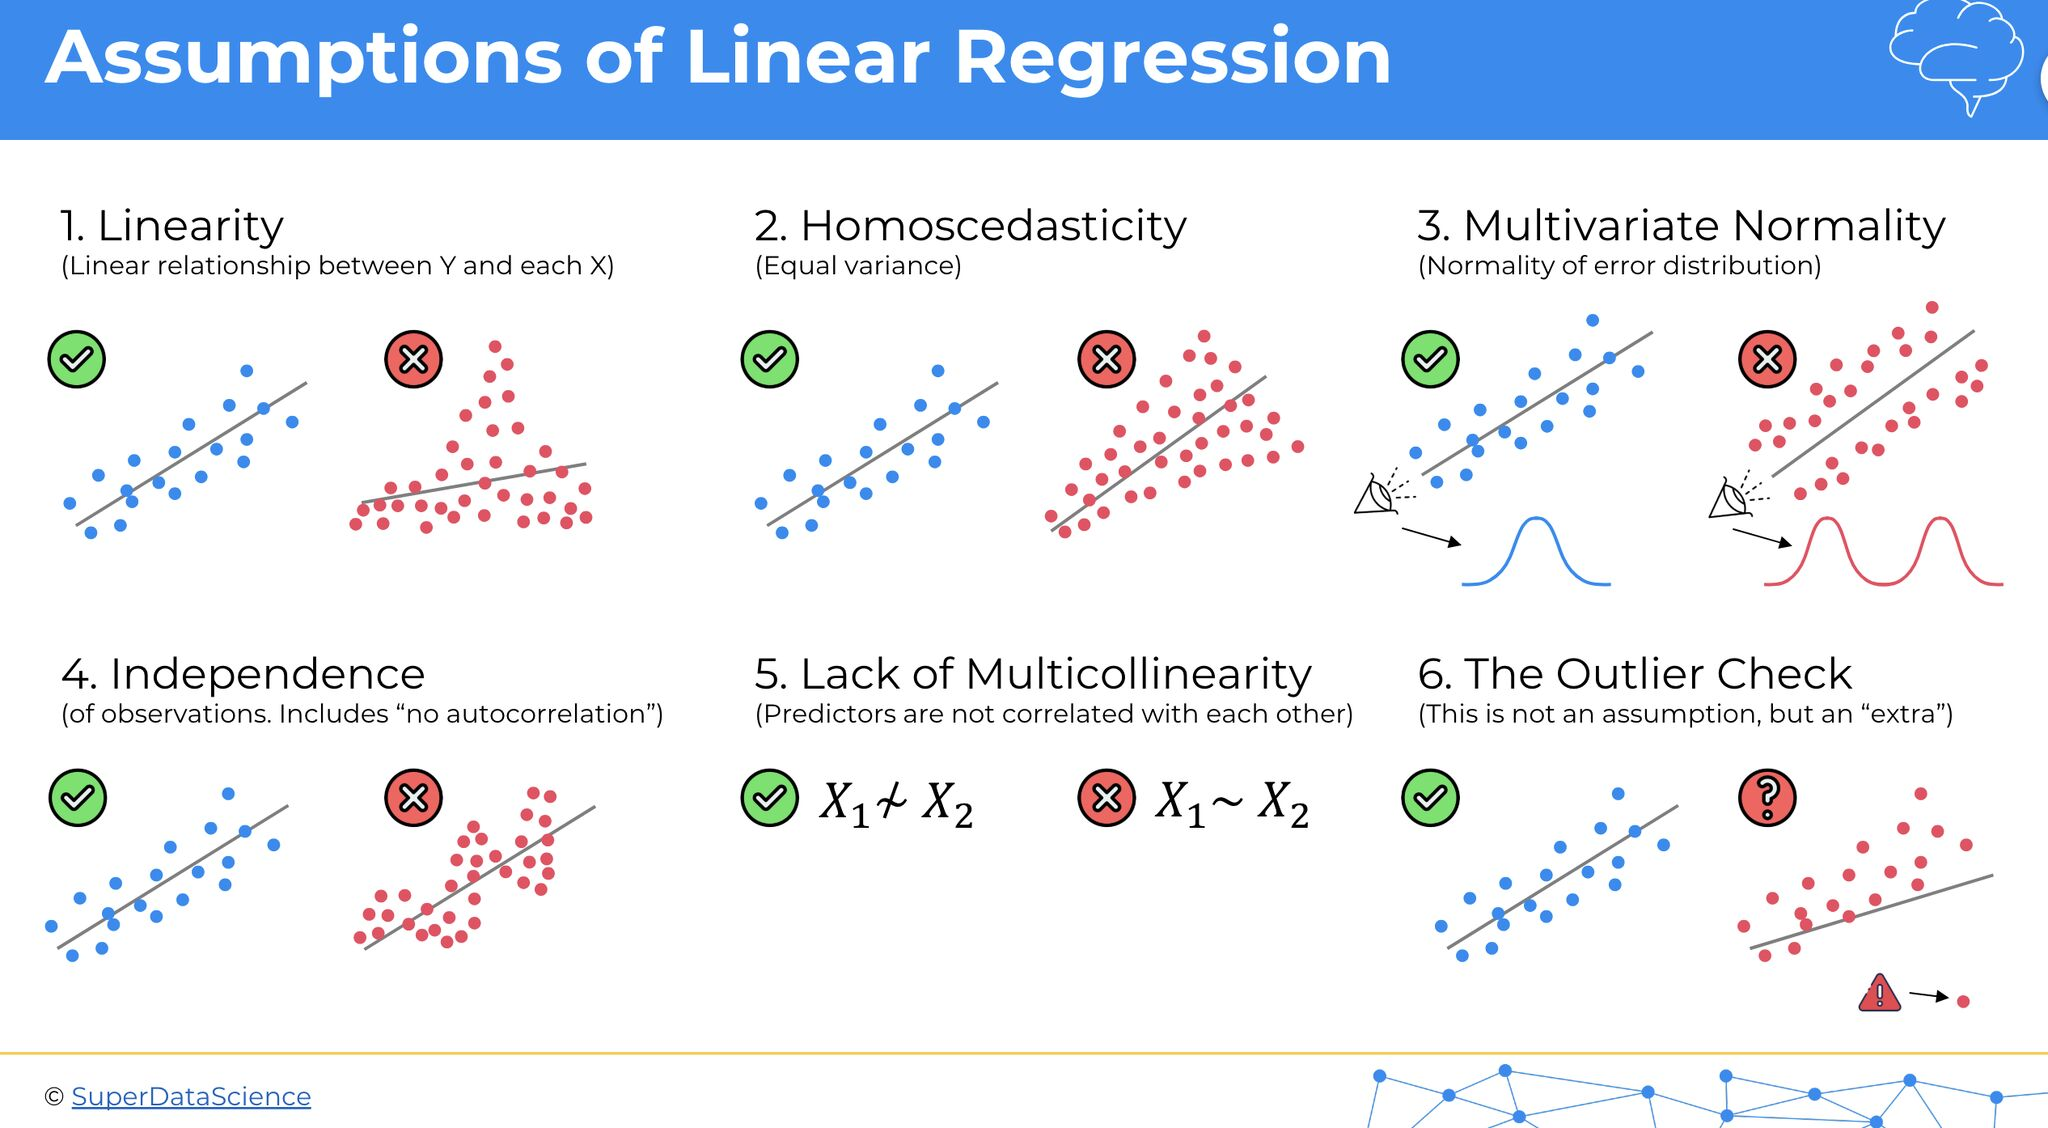

#### One-way

In [28]:
idx_male = dataSF.loc[:, "Gender"] == "Male"
dataSF_M = dataSF.loc[idx_male, :]
dataSF_F = dataSF.loc[~idx_male, :]

#Males
print("MALES")
aov = pg.anova(dv='Satisfaction', between='Fav_Mex_Res', data=dataSF_M,
               detailed=True)
print("Means")
print(np.round(dataSF_M.groupby(["Fav_Mex_Res"]).mean(numeric_only = True)["Satisfaction"],2))
print("Males who prefer one or the other restaurant do not vary in their satisfaction of Santa Fe (see p value)")
print("\n", aov.round(3))

MALES
Means
Fav_Mex_Res
Jose's Southwestern Cafe    4.75
Santa Fe Grill              4.70
Name: Satisfaction, dtype: float64
Males who prefer one or the other restaurant do not vary in their satisfaction of Santa Fe (see p value)

         Source       SS   DF     MS      F  p-unc    np2
0  Fav_Mex_Res    0.153    1  0.153  0.149    0.7  0.001
1       Within  269.540  262  1.029    NaN    NaN    NaN


In [30]:
#Females
print("\nFEMALES")
aov = pg.anova(dv='Satisfaction', between='Fav_Mex_Res', data=dataSF_F,
               detailed=True)
print("Means")
print(np.round(dataSF_F.groupby(["Fav_Mex_Res"]).mean(numeric_only = True)["Satisfaction"],2))
print("Females do vary in their satisfaction of Santa Fe (see p value). Those who prefer Jose's report higher satisfaction")
print("\n", aov.round(3))
aov.round(3)


FEMALES
Means
Fav_Mex_Res
Jose's Southwestern Cafe    6.08
Santa Fe Grill              4.18
Name: Satisfaction, dtype: float64
Females do vary in their satisfaction of Santa Fe (see p value). Those who prefer Jose's report higher satisfaction

         Source       SS   DF       MS        F  p-unc    np2
0  Fav_Mex_Res  125.681    1  125.681  174.585    0.0  0.557
1       Within  100.064  139    0.720      NaN    NaN    NaN


,Source,SS,DF,MS,F,p-unc,np2
0,Fav_Mex_Res,125.681,1,125.681,174.585,0.0,0.557
1,Within,100.064,139,0.720,NaN,NaN,NaN


### Discuss
Women clients seem to differ from men, higher income and lower satisfaction relative to the competition. 

What would you recommend Santa Fe's owners? A gender strategy?


## Non-Parametric

The basic idea is to not assume that the variables have a distribution. In particular, many non-parametric test rank the values of the variables and check if similar values have similar ranks (null) or not.

We will implement the tests with linear regressions and packages' functions, so that you can choose. However, it is good to use regressions to see that non-parametric tests are regressions on ranks. Also to note that the non-parametric label is a claim about the variable, that we rank in non-parametric tests. It is not about not the test statistic (which does have a distribution).

### Compare means (one sample)
The non-parametric version we just need to rank the values.

Income seems to be not normal, even after dropping outliers. Better to confirm differences with a non-parametric test.

In [32]:
# Wilcoxon signed-rank test
#Traditionally
print("Wilcoxon signed-rank test: \n", stats.wilcoxon(dataSF_r.loc[:, "Income"]-50000), "\n")


Wilcoxon signed-rank test: 
 WilcoxonResult(statistic=27602.0, pvalue=4.477401847280583e-08) 



### Compare samples (two independent samples)

Now a two independent sample Mann-Whitney U test


In [36]:
#Two sample independent Mann-Whitney test
#Traditionally
idx = dataSF_r.loc[:, "Fav_Mex_Res"] == 'Santa Fe Grill'
santafe = dataSF_r.loc[idx, :]
joses = dataSF_r.loc[~idx, :]

print("Santa Fe income (mean): ", santafe.loc[:, "Income"].mean())
print("Joses income (mean): ", joses.loc[:, "Income"].mean())
print("Mann-whitneyu test: \n", stats.mannwhitneyu(santafe.loc[:, "Income"], joses.loc[:, "Income"]), "\n")


Santa Fe income (mean):  57135.458167330675
Joses income (mean):  79476.82119205299
Mann-whitneyu test: 
 MannwhitneyuResult(statistic=13410.0, pvalue=8.910867744327678e-07) 



### Compare samples (two dependent samples)

In [38]:
#Traditionally
print("Wilcoxon signed-rank test: \n", stats.wilcoxon(dataSF_panel.loc[:, "Income"]-dataSF_panel.loc[:, "Income_t2"]), "\n")


Wilcoxon signed-rank test: 
 WilcoxonResult(statistic=19055.0, pvalue=3.571933224943288e-20) 



### Compare proportions ($\chi^2$, binomial test)

In [40]:
#Count frequencies and total of favorite mexican restaurant by gender
Freq = pd.crosstab(dataSF.Fav_Mex_Res, dataSF.Gender)
#print(Freq)
F = np.array(Freq).sum(axis=0)[0]
M = np.array(Freq).sum(axis=0)[1]
Joses = np.array(Freq).sum(axis=1)[0]
Santafe = np.array(Freq).sum(axis=1)[1]
TOTAL = F+M
print("Female (%)", F/TOTAL, "\n") #Few female, regardless of restaurant


Female (%) 0.34814814814814815 

Empirical %: 
 Jose_F:  0.42105263157894735 
 Jose_M:  0.5789473684210527 
 Santafe_F:  0.30434782608695654 
 Santafe_M:  0.6956521739130435 

Hypothesized/Expected % (% are independent of restaurant): 
 Jose_F:  0.34814814814814815 
 Jose_M:  0.6518518518518519 
 Santafe_F:  0.34814814814814815 
 Santafe_M:  0.6518518518518519 

Chi square test p val:  0.022638656417734285
Effect size (Cohen's W): 0.1392


In [ ]:
#Chi-Square test
res = stats.chi2_contingency(Freq) #the expected_freq is using only the marginals i.e. each cell is independent


print("Empirical %: \n",
      "Jose_F: ", Freq.loc["Jose's Southwestern Cafe", "Female"]/Joses, "\n", 
      "Jose_M: ", Freq.loc["Jose's Southwestern Cafe", "Male"]/Joses, "\n", 
      "Santafe_F: ", Freq.loc["Santa Fe Grill","Female"]/Santafe, "\n", 
      "Santafe_M: ", Freq.loc["Santa Fe Grill","Male"]/Santafe, "\n")
print("Hypothesized/Expected % (% are independent of restaurant): \n",
      "Jose_F: ", F/TOTAL, "\n", 
      "Jose_M: ", M/TOTAL, "\n", 
      "Santafe_F: ", F/TOTAL, "\n", 
      "Santafe_M: ", M/TOTAL, "\n")

print("Chi square test p val: ", res.pvalue) #p<0.05: reject the null of independence. The frequencies are not independent of the restaurant, preference depends on gender
print("Effect size (Cohen's W): %.4f" % power_chi2(dof=1, n=Freq.sum().sum(), power=0.80, alpha=0.05)) #small effect: w = 0.10; medium effect: w = 0.30; large effect: w = 0.50.


In [41]:
#Binomial test:
#For post-hoc evaluations of the chi square test
binom_Joses_F = stats.binomtest(Freq.iloc[0,0], Joses, p = Freq.iloc[1,0]/Santafe, alternative='two-sided')
binom_Joses_M = stats.binomtest(Freq.iloc[0,1], Joses, p = Freq.iloc[1,1]/Santafe, alternative='two-sided')
binom_Santafe_F = stats.binomtest(Freq.iloc[1,0], Santafe, p = Freq.iloc[0,0]/Joses, alternative='two-sided')
binom_Santafe_M = stats.binomtest(Freq.iloc[1,1], Santafe, p = Freq.iloc[0,1]/Joses, alternative='two-sided')
#multiple comparisons corrections
pvals = sm.stats.multipletests([binom_Joses_F.pvalue, #Female Jose's vs Santa Fe
                                binom_Joses_M.pvalue, #Male Jose's vs Santa Fe
                                binom_Santafe_F.pvalue, #Female Santa Fe vs Jose's
                                binom_Santafe_M.pvalue] #Male Santa Fe vs Jose's
                              )
print("\nPost-hoc binomial test (corrected p values for multiple comparisons): ", 
      pvals[1], "\nJose's is preferred by females, while males prefer Santa Fe (see Empirical % table)") 


Post-hoc binomial test (corrected p values for multiple comparisons):  [0.00518308 0.00518308 0.00064645 0.00064645] 
Jose's is preferred by females, while males prefer Santa Fe (see Empirical % table)


# Exercise (mean + distribution tests)

1) Calculate the mean of Prob_Recommend for women and men

2) Compare this variable (Prob_Recommend), with a 2 independent sample t-test. What does the t-test tell you? Specifically, does the probability to recommend significantly differs between genders?
    * Is the variable normally distributed (do a shapiro test)?.
    * Are the variances similar (do a Levene's test)?
    * Do you think we should continue using a t-test?

3) Let's do a proportion test with a chi-square test with the same variable.
    * Count frequencies of responses in each gender for the variable Prob_Recommend
    * Do a chi-square test. Is it significant? What does it mean?
    * Bonus: do post-hoc binomial tests.

# Appendix

### Same tests with linear regression

#### Is it linear regression?

![Alt text](allways.png)

![Alt text](linear_tests_cheat_sheet.png)

#### Parametric

##### Compare means (one-sample)

In [6]:
#Run the t-test with a regression. 
#A model with just the intercept in an OLS is the mean of the data
model = smf.ols("I(Income-50000) ~ 1", data = dataSF_r) #If the intercept is significant, then the mean is higher(+Est)/lower(-Est) than the reference
results = model.fit()
print(results.summary()) 
#Even without outliers, the Jarque-Bera (JB) test p<0.05 i.e. residuals not normal
#We will return to this later. 
#Durbin - Watson (auto-regression of residuals) is good, around 2.
#No F-statistic because just intercept.

                            OLS Regression Results                            
Dep. Variable:      I(Income - 50000)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 17 Sep 2024   Prob (F-statistic):                nan
Time:                        17:10:47   Log-Likelihood:                -4882.7
No. Observations:                 402   AIC:                             9767.
Df Residuals:                     401   BIC:                             9771.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.553e+04   2275.659      6.823      0.0

##### Compare means (two independent-samples)

In [37]:
#With a regression
model = smf.ols("Income_SR ~ Fav_Mex_Res", data = dataSF_r) #If the intercept is significant, then the mean is higher(+Est)/lower(-Est) than the reference
results = model.fit() #model.fit(use_t = False)
print(results.summary())  

                            OLS Regression Results                            
Dep. Variable:              Income_SR   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     33.07
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           1.77e-08
Time:                        17:51:41   Log-Likelihood:                -2741.6
No. Observations:                 402   AIC:                             5487.
Df Residuals:                     400   BIC:                             5495.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

##### Compare means (two dependent samples)

In [1]:
#With a regression
model = smf.ols("I(Income_t2-Income) ~ 1", data = dataSF_panel)
results = model.fit()
print(results.summary()) 

NameError: name 'smf' is not defined

##### Compare means (ANOVA)

In [30]:
#One-way
# An ANOVA is a regression with categorical variables
# See the F value and p-value, identical as before
# The intercept is the mean of the reference restaurant i.e. does not appear
# The coef. is the difference to the other 
#i.e reference restaurant  = intercept + coef
model = smf.ols("Satisfaction ~ Fav_Mex_Res", data = dataSF_M)
results = model.fit()
print("MALE\n", results.summary())

model = smf.ols("Satisfaction ~ Fav_Mex_Res", data = dataSF_F)
results = model.fit()
print("\nFEMALE\n", results.summary())


MALE
                             OLS Regression Results                            
Dep. Variable:           Satisfaction   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1491
Date:                Sun, 21 Apr 2024   Prob (F-statistic):              0.700
Time:                        13:44:46   Log-Likelihood:                -377.34
No. Observations:                 264   AIC:                             758.7
Df Residuals:                     262   BIC:                             765.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercep

##### N-way
Let's continue with the regression approach. Unifying procedures and seeing that different analyses are actually the same is much more simple.

What if we want to cross N categorical variables? That is an N-way anova

In [31]:
model = smf.ols("Satisfaction ~ Fav_Mex_Res*Gender", data = dataSF)
results = model.fit(cov_type="HC3")
print(results.summary()) 
#The interaction term is a change in slope i.e. relative to the Fav_Mex_Res coef
#In concrete words, the drop in satisfaction from Jose's to Santa Fe is softer for males
#almost zero (-1.8963 + 1.8452; confirm with the means calculated in previous cells)


                            OLS Regression Results                            
Dep. Variable:           Satisfaction   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     59.25
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           9.99e-32
Time:                        13:44:50   Log-Likelihood:                -556.15
No. Observations:                 405   AIC:                             1120.
Df Residuals:                     401   BIC:                             1136.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

#### Non-Parametric

##### Compare means (one-sample)

In [35]:
#With a regression
diff = dataSF_r.loc[:, "Income"]-(50000 + np.pi) #add a small float value to avoid ties. It works because incomes are all integers
rank = np.argsort(np.abs(diff))
signed_rank = rank*np.sign(diff)
dataSF_r.insert(dataSF_r.shape[1], "Income_SR", signed_rank)
model = smf.ols("Income_SR ~ 1", data = dataSF_r) #If the intercept is significant, then the mean is higher(+Est)/lower(-Est) than the reference
results = model.fit() #model.fit(use_t = False)
print(results.summary()) 
#The t stat is not the same as the wilcoxon stat ... 
# .... the non-parametric is a claim about the variable, not the test statistic.

                            OLS Regression Results                            
Dep. Variable:              Income_SR   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 17 Sep 2024   Prob (F-statistic):                nan
Time:                        17:51:35   Log-Likelihood:                -2757.6
No. Observations:                 402   AIC:                             5517.
Df Residuals:                     401   BIC:                             5521.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.9577     11.517      1.907      0.0

##### Compare means (two independent samples)

##### Compare means (two dependent samples)

In [39]:
#With a regression
diff = dataSF_panel.loc[:, "Income_t2"]  - dataSF_panel.loc[:, "Income"]
rank = np.argsort(np.abs(diff))
signed_rank = rank*np.sign(diff)
dataSF_panel.insert(dataSF_panel.shape[1], "Income_SR", signed_rank)
model = smf.ols("Income_SR ~ 1", data = dataSF_panel) #If the intercept is significant, then the mean is higher(+Est)/lower(-Est) than the reference
results = model.fit() #model.fit(use_t = False)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Income_SR   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 17 Sep 2024   Prob (F-statistic):                nan
Time:                        17:52:03   Log-Likelihood:                -2735.9
No. Observations:                 402   AIC:                             5474.
Df Residuals:                     401   BIC:                             5478.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     76.9378     10.912      7.051      0.0

##### Compare proportions

## Bayesian approach

In all the previous tests we test the data against an hypothesis. We assumed that a null hypothesis is true, and ask how likely is the data under the null hypothesis.

In the Bayesian approach we flip the logic. We ask how likely are different hypotheses given a fixed data set.

## Posteriors, priors, & likelihoods

| Prior (beliefs)  | <font size = '20'>   <pre>  </pre> </font>  | Likelihood (data) |   
|:---:|---|:---:|
| <img src="1_CB/EV_vs_GAS.jpg" width = "300" height = '300'> |  |  <img src="1_CB/Lithium_Needs.png" width = "500" height = '500'>  |  


| Prior (beliefs)  | <font size = '20'>   <pre>  </pre> </font>  | Likelihood (data) |   
|:---:|---|:---:|
| <img src="1_CB/SBF.webp" width = "400" height = '400'> |  |  <img src="1_CB/SBF_2.png" width = "500" height = '500'>  |  


| Prior (beliefs)  | <font size = '20'>   <pre>  </pre> </font>  | Likelihood (data) |   
|:---:|---|:---:|
| <img src="1_CB/AGI.jpg" width = "300" height = '300'> |  |  <img src="1_CB/vanRooij.png" width = "400" height = '400'>  |  


| Prior (beliefs)  | <font size = '20'>   <pre>  </pre> </font>  | Likelihood (data) |   
|:---:|---|:---:|
| This X market segment will grow |  |  Sales from that segment grew  |  



Bayes found how to combine priors y likelihoods


$$ Posterior = \frac{Prior \times Likelihood}{Marginal} $$

Same formula, different "names"

$$ Belief_{t+1} = \frac{Belief_t \times Likelihood}{Marginal} $$

Same formula expanded


$$ p(Hypothesis|Data) = \frac{p(Hypothesis) \times p(Data|Hypothesis)}{p(Data)} $$

## Theorem's proof

<center><img src="1_CB/Bayes6.svg" width = "600" height = '600'></center> 


<center><img src="1_CB/Bayes7.svg" width = "600" height = '600'></center> 


<center><img src="1_CB/Bayes8.svg" width = "600" height = '600'></center> 


## Visualization of posteriors, priors, y likelihoods

### Hipotheses space (events)
<center><img src="1_CB/Bayes9.svg" width = "400" height = '400'></center> 


### Hipotheses space (events)
<center><img src="1_CB/Bayes10.svg" width = "400" height = '400'></center> 


### Priors
<center><img src="1_CB/Bayes11.svg" width = "600" height = '600'></center> 


### Data
Marginal: overall probability of the data, across all priors (gray divided by the hypotheses space area)


<center><img src="1_CB/Bayes12.svg" width = "550" height = '550'></center> 


### Likelihoods
<center><img src="1_CB/Bayes13.svg" width = "550" height = '550'></center> 


<center><img src="1_CB/Bayes14.svg" width = "550" height = '550'></center> 



<center><img src="1_CB/Bayes15.svg" width = "550" height = '550'></center> 


### Posterior

<center><img src="1_CB/Bayes16.svg" width = "550" height = '550'></center> 


### Posterior vs. likelihood
<center><img src="1_CB/Bayes17.svg" width = "700" height = '700'></center> 

## A simple binary case

Frequentist probability: frequency of events; there is a point estimate

|Problem|Data|$\theta$|
|:-------:|:-------:|:-------:|
|<img src="2_CB/Coin_cara.png" width = "105" height = '105'>|1 head, 6 tails|$\frac{1}{7}$|

Bayesian probability: beliefs; there is a distribution over the potential estimate

|Problem|Data|$\theta$|
|:-------:|:-------:|:-------:|
|<img src="2_CB/Coin_cara.png" width = "105" height = '105'>|1 head, 6 tails|<img src="2_CB/beta.svg" width = "200" height = '200'>|


Bayes lure: 

We can combine prior knowledge about an hypothesis ($p(\theta))$ and update that prior with data to obtain a new posterior belief/knowledge ($p(\theta|data)$).

$$ p(\theta|data) = \frac{p(data|\theta)p(\theta)}{p(data)}$$

Today's posterior is the future prior

Prior: lands heads 50% of the times. <br>
Data: after 10 throws, only lands heads once <br>
Posterior: lands heads 35% of the times (under some likelihood)

## Where do posteriors come from?

The Bayesian setup requires to define likelihoods and priors to obtain a posterior belief after observing data:
<center><img src="2_CB/bayes_framework.gv.svg" width = "350" height = '350'></center>

The posterior comes from a) analytical solutions or b) computational methods (the majority)

Important Bayesian lesson (visually):

There is a "tug of war" between prior beliefs and likelihood of the data for the final posterior beliefs.

<center><img src="1_CB/Prior_vs_LH.svg" width = "551" height = '550'></center>

## PyMC / Bambi

### Bayesian comparison of means of two independent samples

In [45]:
model = bmb.Model("Income ~ Gender", dataSF_r)
results = model.fit(draws=3000, tune = 1000, chains=4, target_accept=0.9, idata_kwargs={"log_likelihood": True})
posterior = az.extract(results)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Income_sigma, Intercept, Gender]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 98 seconds.


In [27]:
az.summary(results) 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,77175.694,3809.578,70014.298,84325.471,35.003,24.804,11860.0,8243.0,1.0
Gender[Male],-17863.328,4689.205,-26471.129,-8933.072,43.365,31.968,11828.0,8603.0,1.0
Income_sigma,44984.702,1589.492,42017.597,47987.075,13.894,9.842,13152.0,8446.0,1.0


Probability that male clients earn more than female clients:  0.0


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'Gender\nMale'}>,
       <Axes: title={'center': 'Income_sigma'}>], dtype=object)

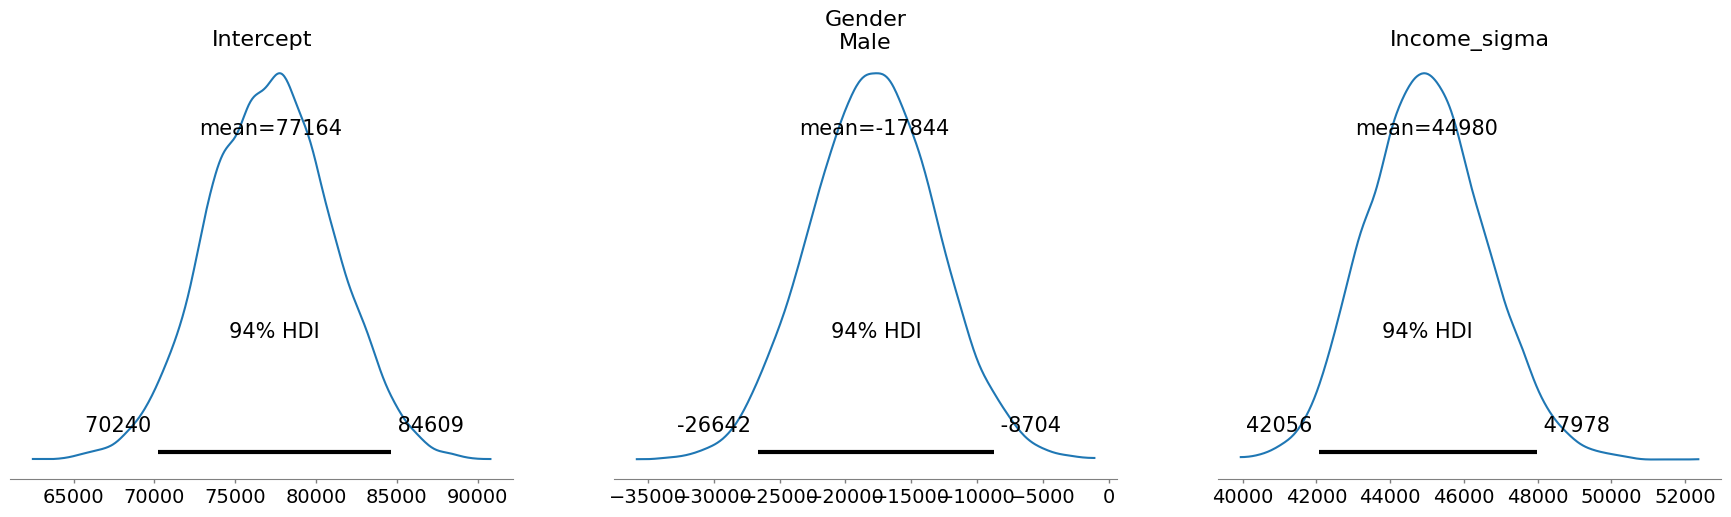

In [51]:
print("Probability that male clients earn more than female clients: ",
     (posterior.Gender.to_numpy()>0).mean())
az.plot_posterior(results) #Compare the mean posterior of gender with the estimate from regular OLS

### Bayesian ANOVA

#### One-way

In [52]:
#Let's say I want to know if male costumer satisfaction differs by their
#favorite mexican restaurant and whether they recall Santa Fe ads.
model = bmb.Model("Satisfaction ~ Fav_Mex_Res + Ad_Recall", data = dataSF_M)
results = model.fit(draws=3000, tune = 1000, chains=4, target_accept=0.9, idata_kwargs={"log_likelihood": True})
posterior_M = az.extract(results)
print(az.summary(results))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Satisfaction_sigma, Intercept, Fav_Mex_Res, Ad_Recall]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 83 seconds.


                              mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                    4.143  0.110   3.946    4.355      0.001   
Fav_Mex_Res[Santa Fe Grill]  0.323  0.119   0.099    0.543      0.001   
Ad_Recall[Recall Ads]        1.243  0.125   1.007    1.475      0.001   
Satisfaction_sigma           0.865  0.038   0.796    0.938      0.000   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                      0.001   10254.0    9095.0    1.0  
Fav_Mex_Res[Santa Fe Grill]    0.001   11300.0    9769.0    1.0  
Ad_Recall[Recall Ads]          0.001   11722.0    9413.0    1.0  
Satisfaction_sigma             0.000   11373.0    9040.0    1.0  


Probability that male clients that prefer Santa Fe grill are more satisfied:  0.9955833333333334
Probability that male clients that watched Santa Fe's add are more satisfied:  1.0


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'Fav_Mex_Res\nSanta Fe Grill'}>,
       <Axes: title={'center': 'Ad_Recall\nRecall Ads'}>,
       <Axes: title={'center': 'Satisfaction_sigma'}>], dtype=object)

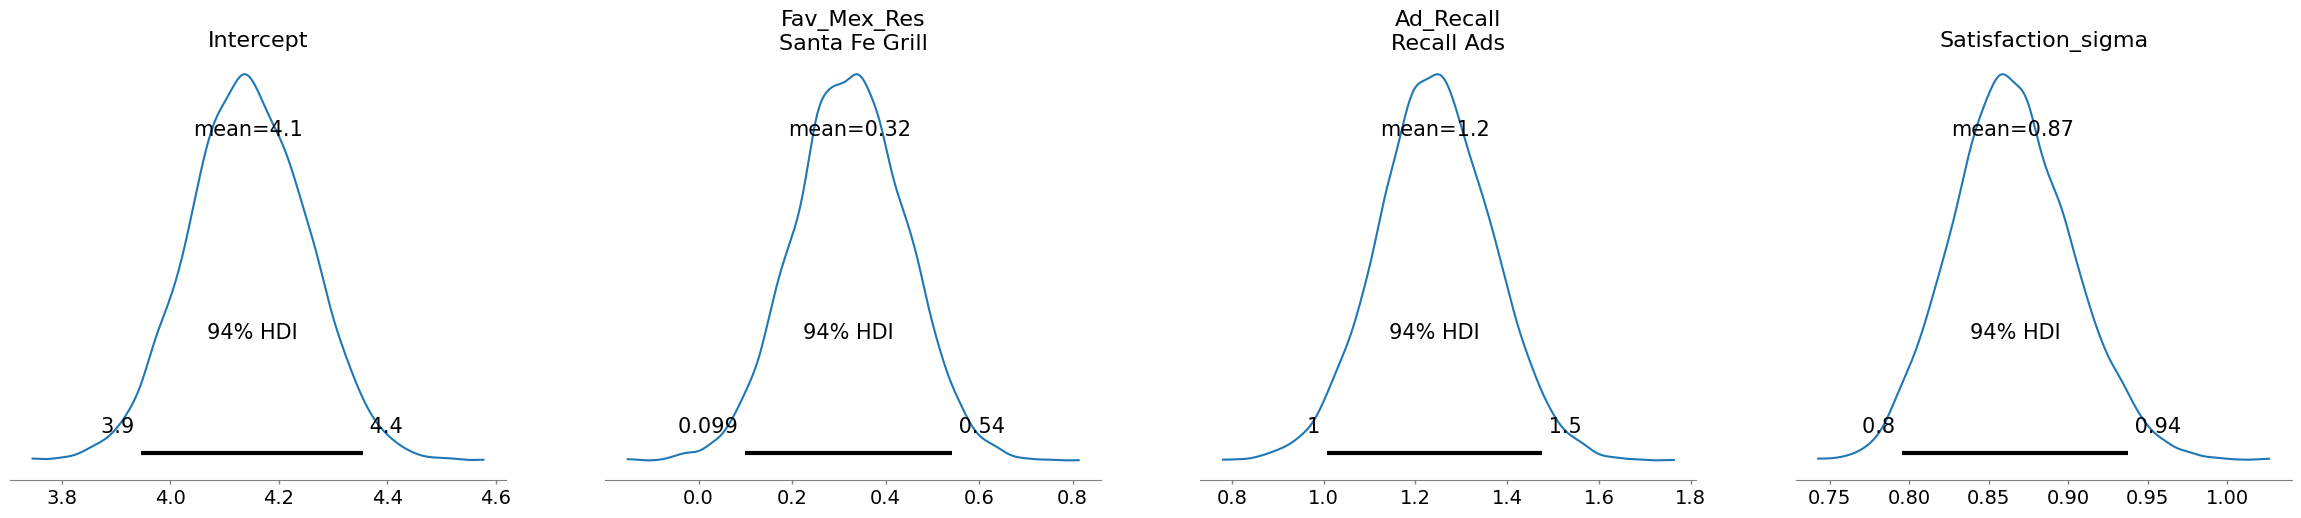

In [67]:
print("Probability that male clients that prefer Santa Fe grill are more satisfied: ",
     (posterior_M.Fav_Mex_Res.to_numpy()>0).mean())
print("Probability that male clients that watched Santa Fe's add are more satisfied: ",
     (posterior_M.Ad_Recall.to_numpy()>0).mean())
az.plot_posterior(results)

#### N-way

In [69]:
#Let's say I want to know if costumer satisfaction differs by their
#favorite mexican restaurant, gender and the INTERACTION
model = bmb.Model("Satisfaction ~ Fav_Mex_Res * Gender", data = dataSF)
results = model.fit(draws=3000, tune = 1000, chains=4, target_accept=0.9, idata_kwargs={"log_likelihood": True})
posterior = az.extract(results)
print(az.summary(results))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Satisfaction_sigma, Intercept, Fav_Mex_Res, Gender, Fav_Mex_Res:Gender]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 105 seconds.


                                           mean     sd  hdi_3%  hdi_97%  \
Intercept                                 6.074  0.121   5.846    6.303   
Fav_Mex_Res[Santa Fe Grill]              -1.892  0.165  -2.216   -1.596   
Gender[Male]                             -1.324  0.159  -1.625   -1.026   
Fav_Mex_Res:Gender[Santa Fe Grill, Male]  1.839  0.207   1.461    2.239   
Satisfaction_sigma                        0.962  0.034   0.900    1.027   

                                          mcse_mean  mcse_sd  ess_bulk  \
Intercept                                     0.002    0.001    5784.0   
Fav_Mex_Res[Santa Fe Grill]                   0.002    0.002    5226.0   
Gender[Male]                                  0.002    0.002    5408.0   
Fav_Mex_Res:Gender[Santa Fe Grill, Male]      0.003    0.002    4805.0   
Satisfaction_sigma                            0.000    0.000   10652.0   

                                          ess_tail  r_hat  
Intercept                                   

Probability that clients that prefer Santa Fe grill are more satisfied:  0.0
Probability that male clients are more satisfied:  0.0
Probability that the difference in satisfaction between Santa Fe and Jose preference is more positive in males:  1.0


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Fav_Mex_Res\nSanta Fe Grill'}>,
        <Axes: title={'center': 'Gender\nMale'}>],
       [<Axes: title={'center': 'Fav_Mex_Res:Gender\nSanta Fe Grill, Male'}>,
        <Axes: title={'center': 'Satisfaction_sigma'}>, <Axes: >]],
      dtype=object)

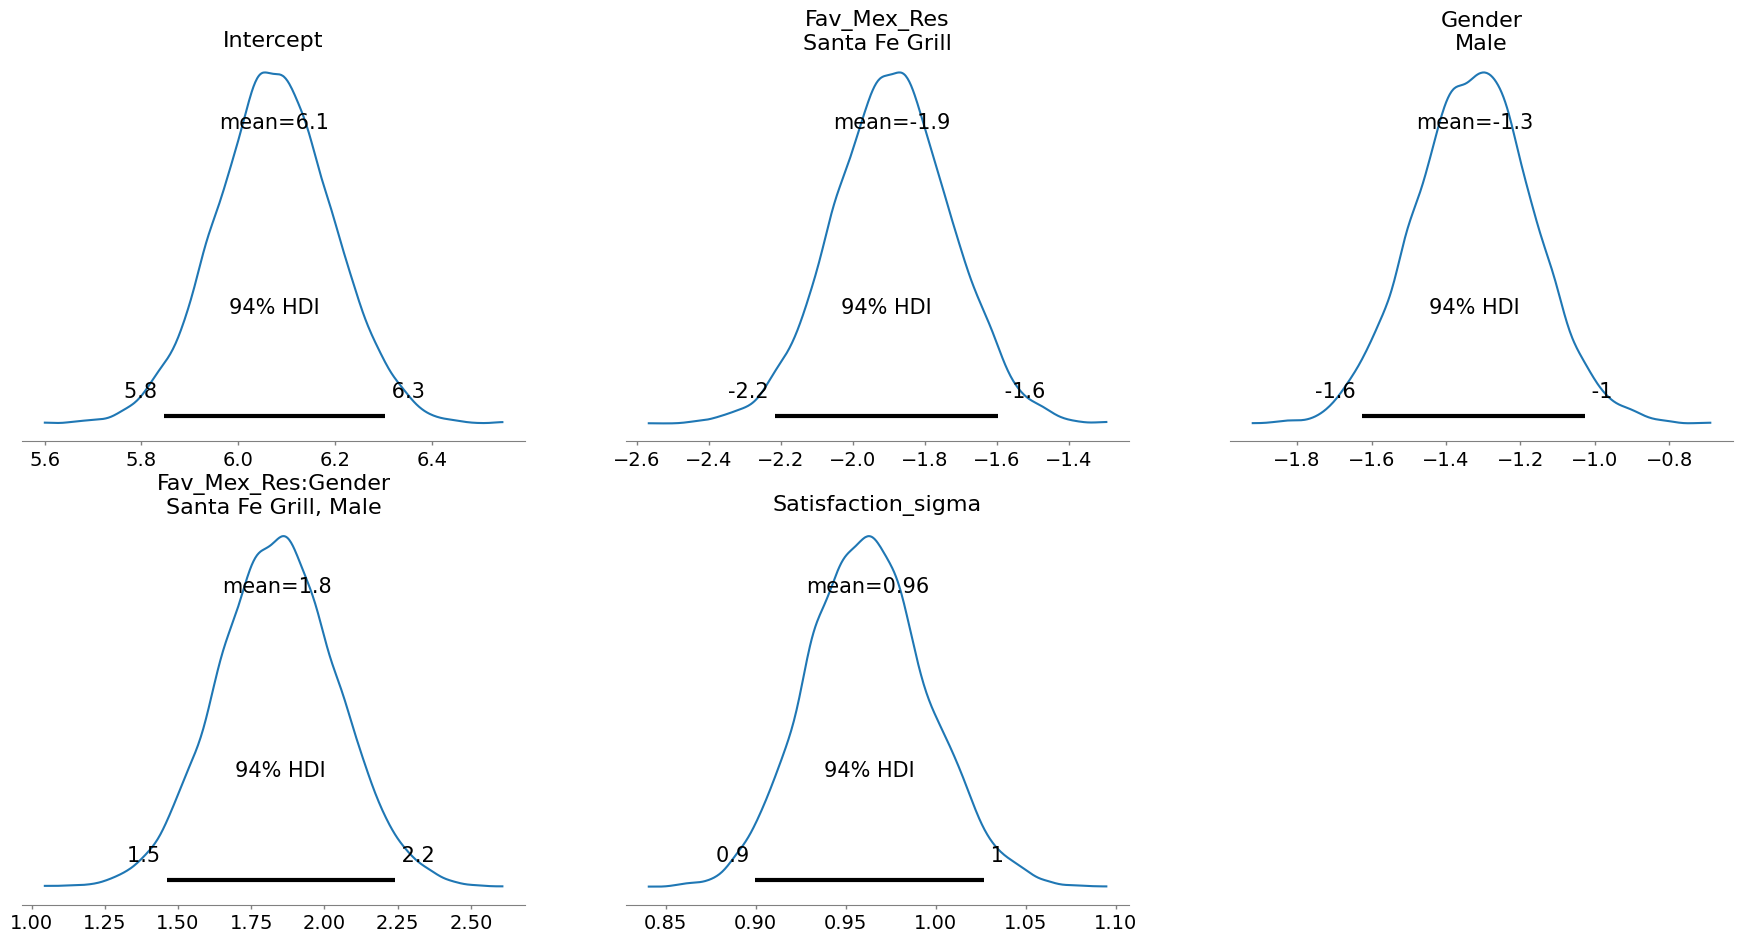

In [76]:
print("Probability that clients that prefer Santa Fe grill are more satisfied: ",
     (posterior.Fav_Mex_Res.to_numpy()>0).mean())
print("Probability that male clients are more satisfied: ",
     (posterior.Gender.to_numpy()>0).mean())
print("Probability that the difference in satisfaction between Santa Fe and Jose preference is more positive in males: ",
     (posterior["Fav_Mex_Res:Gender"].to_numpy()>0).mean())
az.plot_posterior(results)

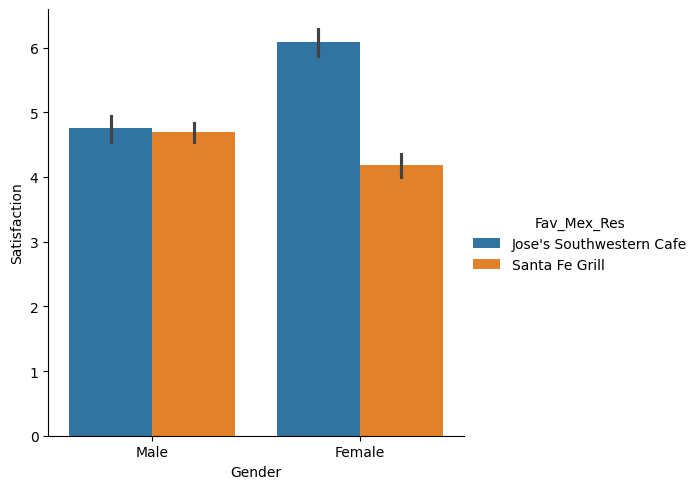

In [82]:
#Plot of the interaction. For males, the difference in bars is close to zero.
#For females, the difference in Jose and Santa Fe is negative i.e. jose's bar is higher
#That is the ~1.83 estimate i.e. in males 0, females -1.83, interaction = 0 - -1.83 = 1.83
sns.catplot(dataSF, x = "Gender" , y = "Satisfaction", hue = "Fav_Mex_Res", kind = "bar");

## Exercise (Bayesian ANOVA)
1) Do this: sns.catplot(dataSF, x = "Gender" , y = "Satisfaction", hue = "Ad_Recall", kind = "bar"). Interpret the graph.

2) Do a Bayesian n-way ANOVA with Satisfaction as the dependent variable, and Gender and Ad_Recall as independent variables. Use the whole data i.e. dataSF.

3) Did it converge? That is, are all the r_hat less than 1.05?

4) Interpret ALL the estimates. Comment if the interaction term is consistent with the barplot that you did before. 
